<a href="https://colab.research.google.com/github/jakariaemon/Segmentation/blob/main/detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Preparing the dataset**

Prepare the dataset using Labelme annotation tool (for Instance segmentation) and LabelImg for object detection.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###**Installing Detectron2 on Colab**

In [2]:
!pip install pyyaml==5.1
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9

     |████████████████████████████████| 274 kB 4.4 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=2a260f01a65ef2052906b68ef7f3f3c3df715923e589857650cd04fc5ef9c67f
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 763.5 MB 16 kB/s 
     |████████████████████████████████| 17.3 MB 782 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Succe

In [3]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# After this step it will ask you to restart the runtime, please do it.

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.3 MB 2.4 MB/s 
     |████████████████████████████████| 50 kB 4.1 MB/s 
     |████████████████████████████████| 145 kB 8.8 MB/s 
     |████████████████████████████████| 130 kB 49.8 MB/s 
     |████████████████████████████████| 74 kB 2.7 MB/s 
     |████████████████████████████████| 843 kB 48.6 MB/s 
     |████████████████████████████████| 749 kB 25.3 MB/s 
     |████████████████████████████████| 112 kB 37.7 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220305-py3-none-any.whl size=61214 sha256=49c9029f27d7f8718d7382268f2adb4ef1c32d5a62027eb85cf5be962c9bb4e4
  Stored in directory: /root/.cache/pip/wheels/b5/b7/6e/43b1693d06fac3633af48db68557513b0a37ab38b0a8b798f9
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=82d5716076db70ab053e6647a2294402781423ddb71615b0d0fbcfaf8a43747

In [5]:
import torch
assert torch.__version__.startswith("1.8") 
import torchvision
import cv2

###**Register the data to Detectron2 config**

In [4]:
import os
import numpy as np
import json
import random
import matplotlib.pyplot as plt
%matplotlib inline

from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

In [16]:
def get_data_dicts(directory, classes):
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        record["height"] = 600
        record["width"] = 800
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']] # x coord
            py = [a[1] for a in anno['points']] # y-coord
            poly = [(x, y) for x, y in zip(px, py)] # poly for segmentation
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [17]:
classes = ['qudacopter']

data_path = '/content/drive/MyDrive/Datasets/data/'

for d in ["train", "test"]:
    DatasetCatalog.register(
        "category_" + d, 
        lambda d=d: get_data_dicts(data_path+d, classes)
    )
    MetadataCatalog.get("category_" + d).set(thing_classes=classes)

microcontroller_metadata = MetadataCatalog.get("category_train")

AssertionError: ignored

###**Training the Detectron2 Instance Segmentation Model**

In [18]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer

In [19]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("category_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

In [20]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

[04/06 17:15:33 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

In [21]:
trainer.train()

[04/06 17:15:40 d2.engine.train_loop]: Starting training from iteration 0
[04/06 17:16:06 d2.utils.events]:  eta: 0:20:39  iter: 19  total_loss: 1.877  loss_cls: 1.066  loss_box_reg: 0.1091  loss_mask: 0.6915  loss_rpn_cls: 0.005989  loss_rpn_loc: 0.004366  time: 1.2411  data_time: 0.0385  lr: 4.9953e-06  max_mem: 2334M
[04/06 17:16:32 d2.utils.events]:  eta: 0:20:18  iter: 39  total_loss: 1.758  loss_cls: 0.959  loss_box_reg: 0.1163  loss_mask: 0.674  loss_rpn_cls: 0.006608  loss_rpn_loc: 0.005179  time: 1.2669  data_time: 0.0076  lr: 9.9902e-06  max_mem: 2335M
[04/06 17:16:59 d2.utils.events]:  eta: 0:20:06  iter: 59  total_loss: 1.47  loss_cls: 0.7064  loss_box_reg: 0.1128  loss_mask: 0.6336  loss_rpn_cls: 0.003787  loss_rpn_loc: 0.004429  time: 1.2922  data_time: 0.0094  lr: 1.4985e-05  max_mem: 2335M
[04/06 17:17:24 d2.utils.events]:  eta: 0:19:38  iter: 79  total_loss: 1.22  loss_cls: 0.4823  loss_box_reg: 0.1098  loss_mask: 0.5938  loss_rpn_cls: 0.004525  loss_rpn_loc: 0.005499 

###**Inference using the Trained Model**

In [22]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = ("skin_test", )
predictor = DefaultPredictor(cfg)

In [23]:
test_dataset_dicts = get_data_dicts(data_path+'test', classes)

In [ ]:
# len(test_dataset_dicts) = 7, 7 dictionaries in a list (7 images for test)
# test_dataset_dicts[0] = each dict containing 4 keys: 'file_name', 'height', 'width', 'annotations'

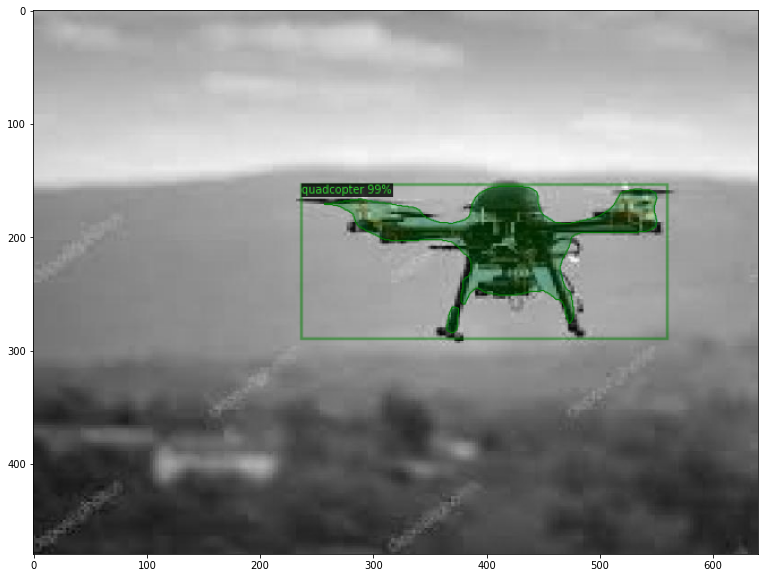

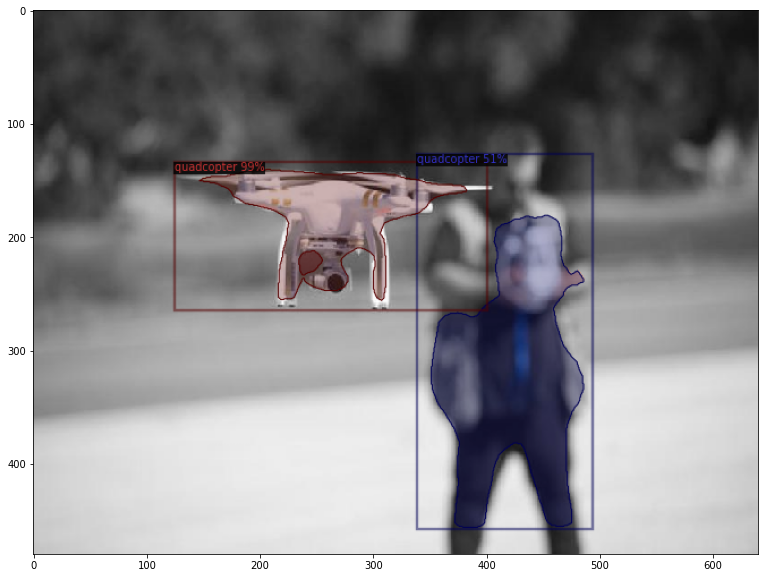

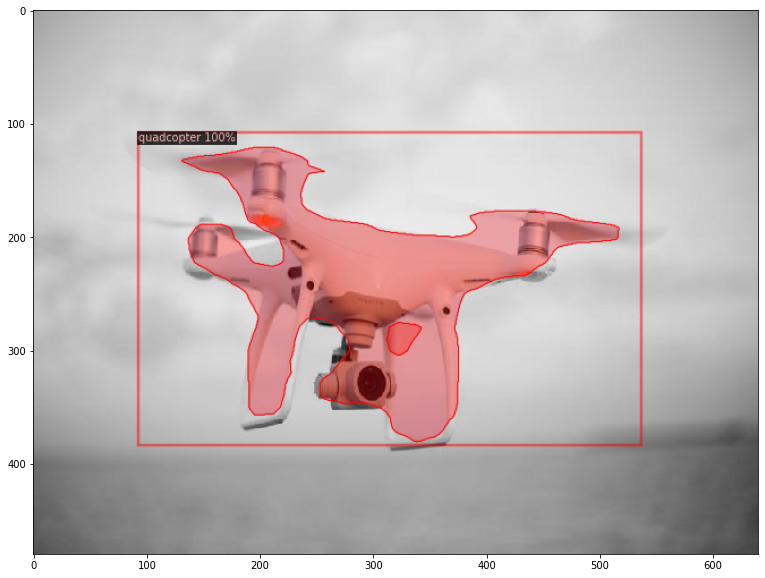

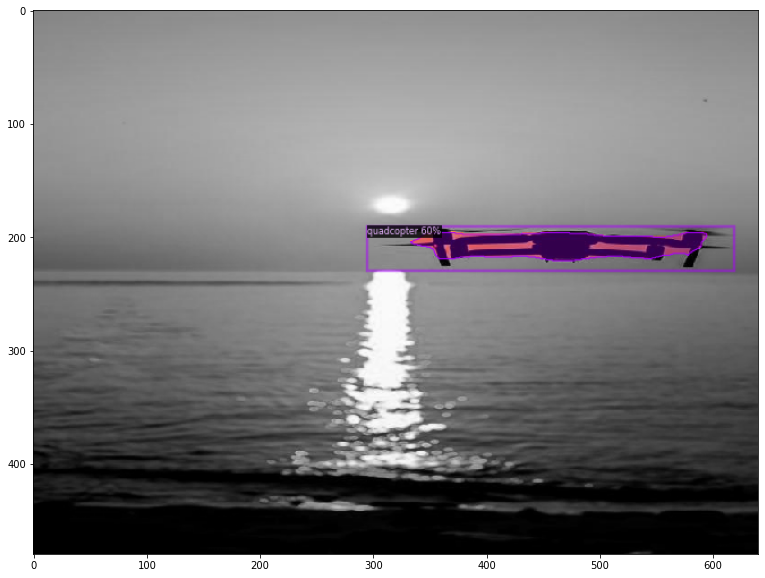

In [27]:
for d in random.sample(test_dataset_dicts, 4):    
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW # removes the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()